# Support Vector Machine (SVM) Model for TANAP Boundaries Prediction

This notebook implements and evaluates a Support Vector Machine model for predicting TANAP boundaries in historical document scans.

## Model Overview
- **Task**: Multi-class classification (NONE, START, MIDDLE, END)
- **Algorithm**: Support Vector Machine with RBF and Linear kernels
- **Features**: XML layout features + XMI NER features + sequence features
- **Advantages**: Effective in high-dimensional spaces, memory efficient, versatile with different kernels

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Data Loading and Preprocessing

In [18]:
# Load the feature dataset
df = pd.read_csv('../data/train/features_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['TANAP Boundaries'].value_counts())
print(f"\nTarget percentages:")
print(df['TANAP Boundaries'].value_counts(normalize=True) * 100)

Dataset shape: (16774, 69)

Target distribution:
TANAP Boundaries
MIDDLE    13058
NONE       1535
START      1091
END        1090
Name: count, dtype: int64

Target percentages:
TANAP Boundaries
MIDDLE    77.846667
NONE       9.151067
START      6.504114
END        6.498152
Name: proportion, dtype: float64


In [19]:
# Prepare features and target
feature_cols = [col for col in df.columns if col not in ['Scan File_Name', 'TANAP Boundaries']]
X = df[feature_cols]
y = df['TANAP Boundaries']

print(f"Number of features: {len(feature_cols)}")

# Handle missing values
missing_data = X.isnull().sum()
if missing_data.sum() > 0:
    print(f"\nMissing values found:")
    print(missing_data[missing_data > 0])
    X = X.fillna(X.median())
else:
    print("\nNo missing values found.")

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("\nLabel encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i}: {label}")

Number of features: 67

No missing values found.

Label encoding:
0: END
1: MIDDLE
2: NONE
3: START


In [20]:
# For SVM, we'll use a smaller subset for computational efficiency
# SVM training time scales quadratically with the number of samples
sample_size = min(5000, len(X))  # Use max 5000 samples for SVM
if len(X) > sample_size:
    print(f"\nNote: Using stratified sample of {sample_size} samples for SVM training (out of {len(X)})")
    print("This is done for computational efficiency as SVM training is computationally expensive.")
    
    # Stratified sampling to maintain class distribution
    from sklearn.model_selection import StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, train_size=sample_size, random_state=42)
    sample_idx, _ = next(splitter.split(X, y_encoded))
    
    X_sample = X.iloc[sample_idx]
    y_sample = y_encoded[sample_idx]
    
    print(f"Sample distribution:")
    print(pd.Series(y_sample).value_counts().sort_index())
else:
    X_sample = X
    y_sample = y_encoded

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nTest set distribution:")
print(pd.Series(y_test).value_counts().sort_index())


Note: Using stratified sample of 5000 samples for SVM training (out of 16774)
This is done for computational efficiency as SVM training is computationally expensive.
Sample distribution:
0     325
1    3892
2     458
3     325
Name: count, dtype: int64

Training set shape: (4000, 67)
Test set shape: (1000, 67)

Training set distribution:
0     260
1    3114
2     366
3     260
Name: count, dtype: int64

Test set distribution:
0     65
1    778
2     92
3     65
Name: count, dtype: int64


## Feature Scaling and Dimensionality Analysis

In [21]:
# Scale features (crucial for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed.")
print(f"Training features mean: {X_train_scaled.mean():.6f}")
print(f"Training features std: {X_train_scaled.std():.6f}")

# Calculate class weights for imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(f"\nClass weights: {class_weight_dict}")

Feature scaling completed.
Training features mean: -0.000000
Training features std: 0.810380

Class weights: {np.int64(0): np.float64(3.8461538461538463), np.int64(1): np.float64(0.32113037893384716), np.int64(2): np.float64(2.73224043715847), np.int64(3): np.float64(3.8461538461538463)}


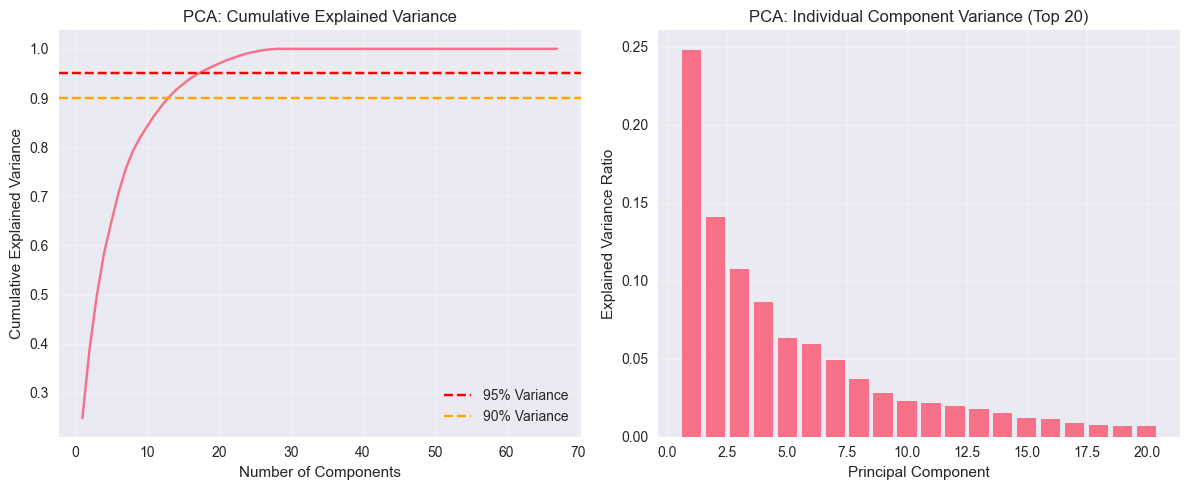


PCA Analysis:
Original features: 67
Components for 90% variance: 13
Components for 95% variance: 18
Variance explained by first component: 0.2482
Variance explained by first 10 components: 0.8422


In [22]:
# Optional: Dimensionality reduction analysis
# PCA to understand feature variance and potentially reduce dimensions
pca_analyzer = PCA()
pca_analyzer.fit(X_train_scaled)

# Plot cumulative explained variance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca_analyzer.explained_variance_ratio_) + 1), 
         np.cumsum(pca_analyzer.explained_variance_ratio_))
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(1, min(21, len(pca_analyzer.explained_variance_ratio_) + 1)), 
        pca_analyzer.explained_variance_ratio_[:20])
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA: Individual Component Variance (Top 20)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components for 95% and 90% variance
cumsum_var = np.cumsum(pca_analyzer.explained_variance_ratio_)
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1
n_components_90 = np.argmax(cumsum_var >= 0.90) + 1

print(f"\nPCA Analysis:")
print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Components for 90% variance: {n_components_90}")
print(f"Components for 95% variance: {n_components_95}")
print(f"Variance explained by first component: {pca_analyzer.explained_variance_ratio_[0]:.4f}")
print(f"Variance explained by first 10 components: {cumsum_var[9]:.4f}")

## Model Training and Hyperparameter Tuning

In [23]:
# Define hyperparameter grid for SVM
# We'll test both linear and RBF kernels
param_grid = [
    {
        'kernel': ['linear'],
        'C': [0.1, 1, 10, 100],
        'class_weight': ['balanced', None]
    },
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.001, 0.01],
        'class_weight': ['balanced', None]
    }
]

# Create SVM model
svm_model = SVC(random_state=42)

print("Starting hyperparameter tuning...")
print("This may take several minutes due to SVM's computational complexity.")

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    svm_model, 
    param_grid, 
    cv=5,  # Reduced CV folds for faster execution
    scoring='f1_weighted', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

Starting hyperparameter tuning...
This may take several minutes due to SVM's computational complexity.
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters: {'C': 10, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}
Best CV score: 0.8572


In [24]:
# Train final model with best parameters
best_svm_model = grid_search.best_estimator_

# Make predictions
y_train_pred = best_svm_model.predict(X_train_scaled)
y_test_pred = best_svm_model.predict(X_test_scaled)

# Calculate training and test scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training F1-score: {train_f1:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

# Get decision function values (for confidence analysis)
if hasattr(best_svm_model, 'decision_function'):
    decision_scores = best_svm_model.decision_function(X_test_scaled)
    print(f"\nDecision function output shape: {decision_scores.shape}")

Training Accuracy: 0.9190
Test Accuracy: 0.8530
Training F1-score: 0.9129
Test F1-score: 0.8396

Decision function output shape: (1000, 4)


## Model Evaluation

In [25]:
# Detailed classification report
class_names = label_encoder.classes_
print("Classification Report:")
print(classification_report(
    y_test, y_test_pred, 
    target_names=class_names,
    digits=4
))

Classification Report:
              precision    recall  f1-score   support

         END     0.3889    0.2154    0.2772        65
      MIDDLE     0.8944    0.9473    0.9201       778
        NONE     0.8172    0.8261    0.8216        92
       START     0.5532    0.4000    0.4643        65

    accuracy                         0.8530      1000
   macro avg     0.6634    0.5972    0.6208      1000
weighted avg     0.8323    0.8530    0.8396      1000



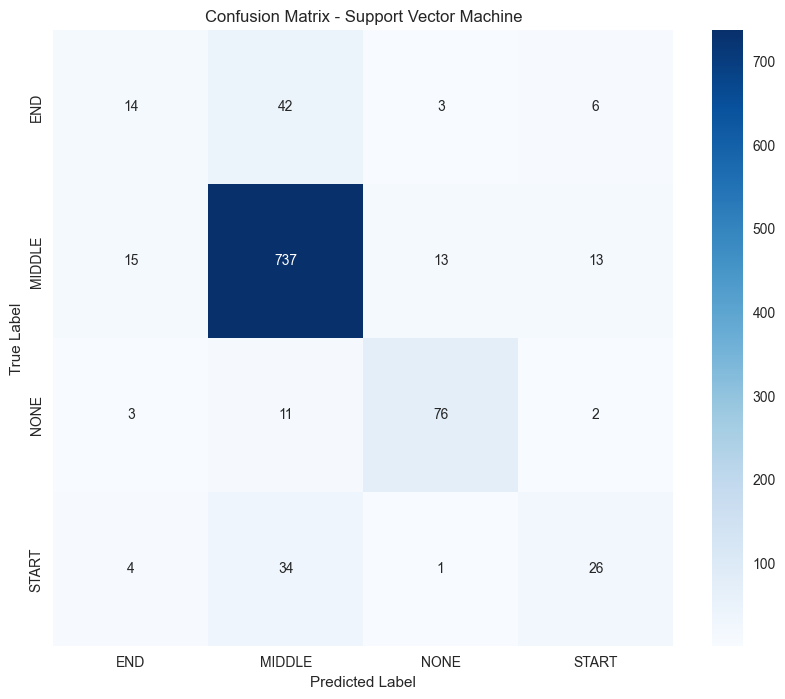


Per-class Metrics:
    Class  Precision  Recall  F1-Score  Support
0     END     0.3889  0.2154    0.2772       65
1  MIDDLE     0.8944  0.9473    0.9201      778
2    NONE     0.8172  0.8261    0.8216       92
3   START     0.5532  0.4000    0.4643       65


In [26]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Support Vector Machine')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_test_pred, average=None
)

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nPer-class Metrics:")
print(metrics_df.round(4))

## SVM-Specific Analysis

SVM Model Analysis:
Kernel: rbf
C parameter: 10
Gamma parameter: auto
Class weight: None
Number of support vectors: [245 666 182 238]
Total support vectors: 1331
Support vector ratio: 0.3327


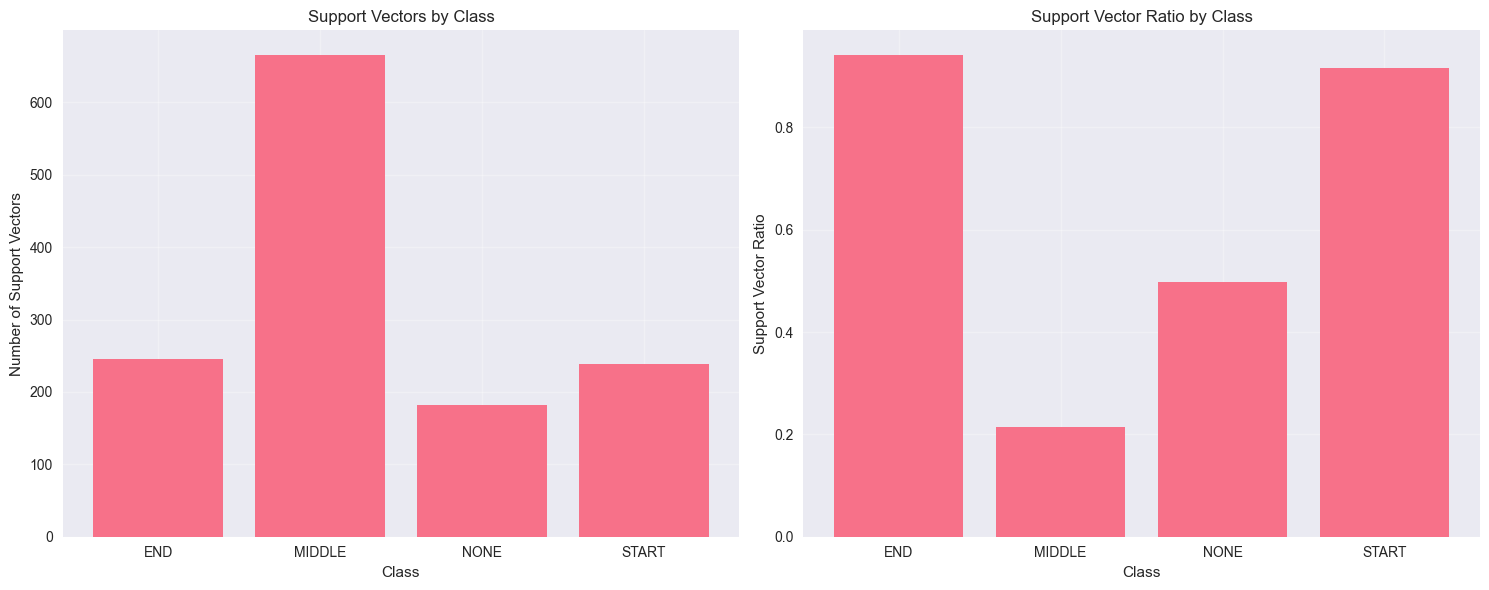


Support vector ratios by class:
END: 0.9423 (245/260)
MIDDLE: 0.2139 (666/3114)
NONE: 0.4973 (182/366)
START: 0.9154 (238/260)


In [27]:
# Analyze SVM-specific properties
print("SVM Model Analysis:")
print(f"Kernel: {best_svm_model.kernel}")
print(f"C parameter: {best_svm_model.C}")
if hasattr(best_svm_model, 'gamma'):
    print(f"Gamma parameter: {best_svm_model.gamma}")
print(f"Class weight: {best_svm_model.class_weight}")
print(f"Number of support vectors: {best_svm_model.n_support_}")
print(f"Total support vectors: {sum(best_svm_model.n_support_)}")
print(f"Support vector ratio: {sum(best_svm_model.n_support_) / len(X_train):.4f}")

# Plot support vector analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Support vectors by class
class_sv_counts = best_svm_model.n_support_
axes[0].bar(range(len(class_names)), class_sv_counts)
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Support Vectors')
axes[0].set_title('Support Vectors by Class')
axes[0].set_xticks(range(len(class_names)))
axes[0].set_xticklabels(class_names)
axes[0].grid(True, alpha=0.3)

# Support vector ratio by class
class_counts = pd.Series(y_train).value_counts().sort_index()
sv_ratios = class_sv_counts / class_counts.values
axes[1].bar(range(len(class_names)), sv_ratios)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Support Vector Ratio')
axes[1].set_title('Support Vector Ratio by Class')
axes[1].set_xticks(range(len(class_names)))
axes[1].set_xticklabels(class_names)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSupport vector ratios by class:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {sv_ratios[i]:.4f} ({class_sv_counts[i]}/{class_counts.iloc[i]})")

## Decision Function Analysis

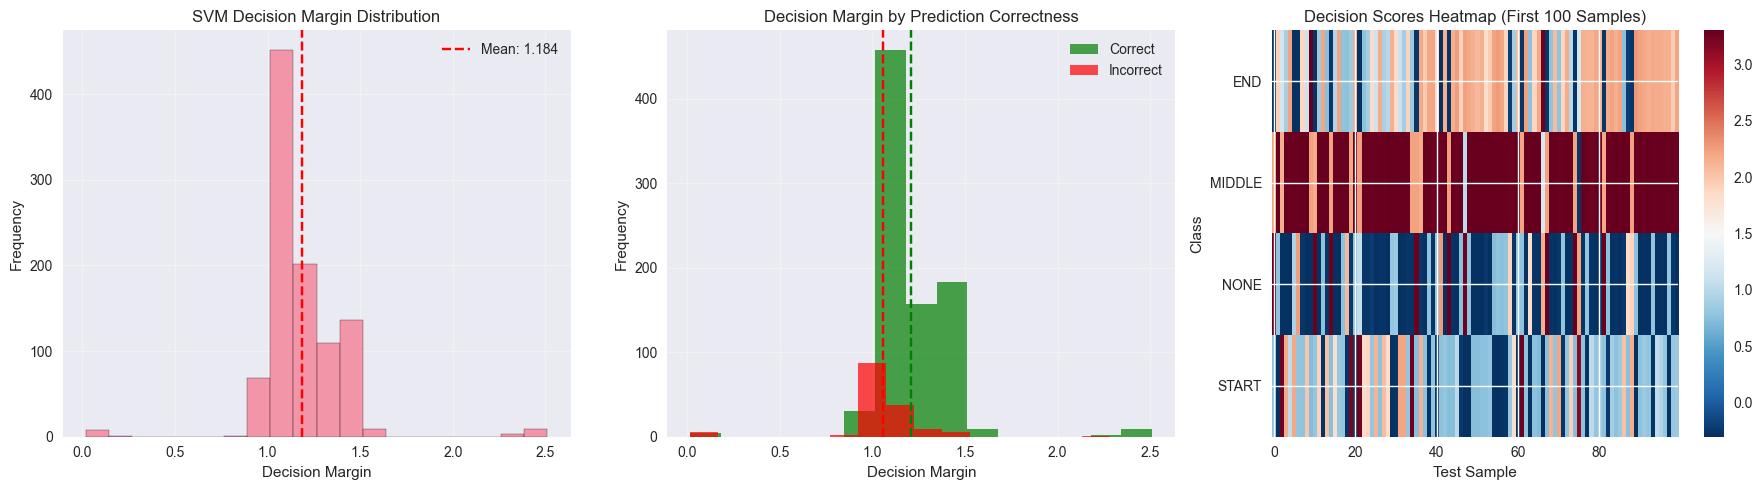


Decision Function Analysis:
Average decision margin: 1.1842
Margin for correct predictions: 1.2063
Margin for incorrect predictions: 1.0562
Margin difference: 0.1501


In [28]:
# Analyze decision function outputs (confidence scores)
if hasattr(best_svm_model, 'decision_function'):
    decision_scores = best_svm_model.decision_function(X_test_scaled)
    
    # For multiclass, decision_function returns a matrix
    if decision_scores.ndim == 2:
        # Calculate confidence as the margin between top two scores
        sorted_scores = np.sort(decision_scores, axis=1)
        confidence_margins = sorted_scores[:, -1] - sorted_scores[:, -2]
        
        # Create confidence analysis
        confidence_df = pd.DataFrame({
            'True_Class': [class_names[i] for i in y_test],
            'Predicted_Class': [class_names[i] for i in y_test_pred],
            'Confidence_Margin': confidence_margins,
            'Correct': y_test == y_test_pred
        })
        
        # Plot confidence analysis
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Overall confidence distribution
        axes[0].hist(confidence_margins, bins=20, alpha=0.7, edgecolor='black')
        axes[0].axvline(np.mean(confidence_margins), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(confidence_margins):.3f}')
        axes[0].set_xlabel('Decision Margin')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('SVM Decision Margin Distribution')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Confidence by correctness
        correct_conf = confidence_df[confidence_df['Correct']]['Confidence_Margin']
        incorrect_conf = confidence_df[~confidence_df['Correct']]['Confidence_Margin']
        
        axes[1].hist(correct_conf, bins=15, alpha=0.7, label='Correct', color='green')
        axes[1].hist(incorrect_conf, bins=15, alpha=0.7, label='Incorrect', color='red')
        axes[1].axvline(np.mean(correct_conf), color='green', linestyle='--')
        axes[1].axvline(np.mean(incorrect_conf), color='red', linestyle='--')
        axes[1].set_xlabel('Decision Margin')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Decision Margin by Prediction Correctness')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Decision scores heatmap (first 100 samples)
        sample_size = min(100, len(decision_scores))
        im = axes[2].imshow(decision_scores[:sample_size].T, aspect='auto', cmap='RdBu_r')
        axes[2].set_xlabel('Test Sample')
        axes[2].set_ylabel('Class')
        axes[2].set_title(f'Decision Scores Heatmap (First {sample_size} Samples)')
        axes[2].set_yticks(range(len(class_names)))
        axes[2].set_yticklabels(class_names)
        plt.colorbar(im, ax=axes[2])
        
        plt.tight_layout()
        plt.show()
        
        print("\nDecision Function Analysis:")
        print(f"Average decision margin: {np.mean(confidence_margins):.4f}")
        print(f"Margin for correct predictions: {np.mean(correct_conf):.4f}")
        print(f"Margin for incorrect predictions: {np.mean(incorrect_conf):.4f}")
        print(f"Margin difference: {np.mean(correct_conf) - np.mean(incorrect_conf):.4f}")
    
else:
    print("Decision function not available for this SVM configuration.")

## Cross-Validation Analysis

Performing cross-validation...
3-Fold Cross-Validation Results:
Accuracy: 0.8637 (+/- 0.0094)
F1-Score: 0.8495 (+/- 0.0090)


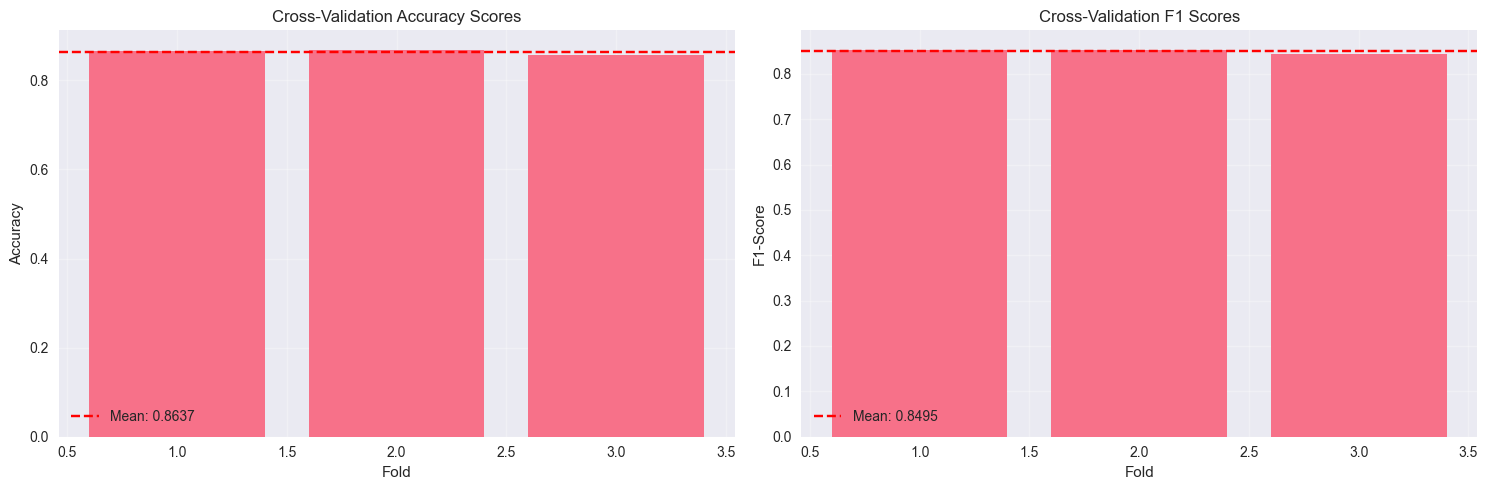

In [29]:
# Perform k-fold cross-validation
print("Performing cross-validation...")
cv_scores_accuracy = cross_val_score(
    best_svm_model, X_train_scaled, y_train, cv=3, scoring='accuracy'  # Reduced CV for speed
)
cv_scores_f1 = cross_val_score(
    best_svm_model, X_train_scaled, y_train, cv=3, scoring='f1_weighted'
)

print("3-Fold Cross-Validation Results:")
print(f"Accuracy: {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_accuracy.std() * 2:.4f})")
print(f"F1-Score: {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")

# Plot CV scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(range(1, 4), cv_scores_accuracy)
ax1.axhline(y=cv_scores_accuracy.mean(), color='r', linestyle='--', 
           label=f'Mean: {cv_scores_accuracy.mean():.4f}')
ax1.set_title('Cross-Validation Accuracy Scores')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.bar(range(1, 4), cv_scores_f1)
ax2.axhline(y=cv_scores_f1.mean(), color='r', linestyle='--', 
           label=f'Mean: {cv_scores_f1.mean():.4f}')
ax2.set_title('Cross-Validation F1 Scores')
ax2.set_xlabel('Fold')
ax2.set_ylabel('F1-Score')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Hyperparameter Search Results Analysis

Top 10 Hyperparameter Combinations:
    param_C param_class_weight param_kernel param_gamma  mean_test_score  \
29     10.0               None          rbf        auto         0.857194   
28     10.0               None          rbf       scale         0.857178   
31     10.0               None          rbf        0.01         0.848440   
24     10.0           balanced          rbf       scale         0.830359   
25     10.0           balanced          rbf        auto         0.822131   
20      1.0               None          rbf       scale         0.819734   
27     10.0           balanced          rbf        0.01         0.816610   
7     100.0               None       linear         NaN         0.814093   
5      10.0               None       linear         NaN         0.813698   
16      1.0           balanced          rbf       scale         0.812301   

    std_test_score  rank_test_score  
29        0.006383                1  
28        0.006402                2  
31        0.0

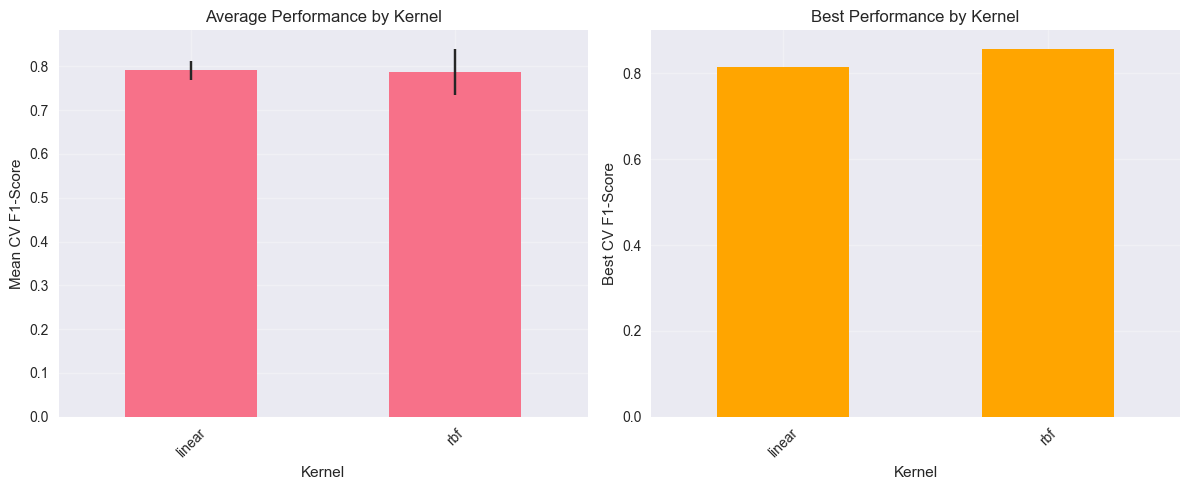


Kernel Performance Summary:
                mean     max     std
param_kernel                        
linear        0.7906  0.8141  0.0211
rbf           0.7874  0.8572  0.0527


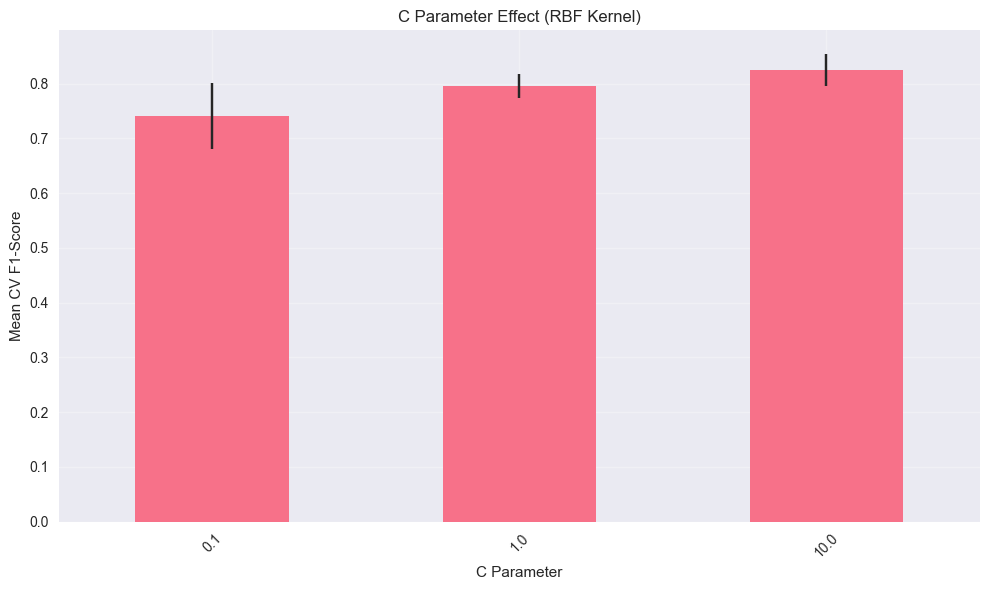

In [30]:
# Analyze hyperparameter search results
results_df = pd.DataFrame(grid_search.cv_results_)

# Extract key results
param_cols = [col for col in results_df.columns if col.startswith('param_')]
score_cols = ['mean_test_score', 'std_test_score', 'rank_test_score']
analysis_df = results_df[param_cols + score_cols].copy()

# Sort by performance
analysis_df = analysis_df.sort_values('rank_test_score')

print("Top 10 Hyperparameter Combinations:")
print(analysis_df.head(10))

# Visualize kernel performance
kernel_performance = analysis_df.groupby('param_kernel')['mean_test_score'].agg(['mean', 'max', 'std'])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
kernel_performance['mean'].plot(kind='bar', capsize=4, 
                               yerr=kernel_performance['std'])
plt.title('Average Performance by Kernel')
plt.ylabel('Mean CV F1-Score')
plt.xlabel('Kernel')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
kernel_performance['max'].plot(kind='bar', color='orange')
plt.title('Best Performance by Kernel')
plt.ylabel('Best CV F1-Score')
plt.xlabel('Kernel')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nKernel Performance Summary:")
print(kernel_performance.round(4))

# Analyze C parameter effect for best kernel
best_kernel = grid_search.best_params_['kernel']
kernel_results = analysis_df[analysis_df['param_kernel'] == best_kernel]

if len(kernel_results) > 1:
    plt.figure(figsize=(10, 6))
    c_performance = kernel_results.groupby('param_C')['mean_test_score'].agg(['mean', 'std'])
    c_performance['mean'].plot(kind='bar', capsize=4, yerr=c_performance['std'])
    plt.title(f'C Parameter Effect ({best_kernel.upper()} Kernel)')
    plt.ylabel('Mean CV F1-Score')
    plt.xlabel('C Parameter')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Results Summary and Analysis

In [31]:
# Create comprehensive results summary
results_summary = {
    'Model': 'Support Vector Machine',
    'Best Parameters': grid_search.best_params_,
    'Kernel': best_svm_model.kernel,
    'C Parameter': best_svm_model.C,
    'Training Accuracy': train_accuracy,
    'Test Accuracy': test_accuracy,
    'Training F1-Score': train_f1,
    'Test F1-Score': test_f1,
    'CV Accuracy Mean': cv_scores_accuracy.mean(),
    'CV Accuracy Std': cv_scores_accuracy.std(),
    'CV F1-Score Mean': cv_scores_f1.mean(),
    'CV F1-Score Std': cv_scores_f1.std(),
    'Number of Features': len(feature_cols),
    'Training Samples': len(X_train),
    'Test Samples': len(X_test),
    'Total Support Vectors': sum(best_svm_model.n_support_),
    'Support Vector Ratio': sum(best_svm_model.n_support_) / len(X_train),
    'Class Weight': best_svm_model.class_weight
}

# Add gamma if available
if hasattr(best_svm_model, 'gamma'):
    results_summary['Gamma Parameter'] = best_svm_model.gamma

# Add decision margin analysis if available
if 'confidence_margins' in locals():
    results_summary['Average Decision Margin'] = np.mean(confidence_margins)
    results_summary['Margin Correct Predictions'] = np.mean(correct_conf)
    results_summary['Margin Incorrect Predictions'] = np.mean(incorrect_conf)

print("SUPPORT VECTOR MACHINE MODEL - FINAL RESULTS")
print("=" * 50)
for key, value in results_summary.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Analysis and insights
print("\n" + "=" * 50)
print("ANALYSIS AND INSIGHTS")
print("=" * 50)

# Check for overfitting
if train_accuracy - test_accuracy > 0.05:
    print("⚠️  Potential overfitting detected (training accuracy >> test accuracy)")
else:
    print("✅ Good generalization (no significant overfitting)")

# Model performance assessment
if test_accuracy > 0.8:
    print("✅ High model performance (accuracy > 80%)")
elif test_accuracy > 0.7:
    print("⚡ Moderate model performance (accuracy 70-80%)")
else:
    print("⚠️  Low model performance (accuracy < 70%)")

# Support vector analysis
sv_ratio = results_summary['Support Vector Ratio']
if sv_ratio < 0.1:
    print("✅ Efficient model (low support vector ratio < 10%)")
elif sv_ratio < 0.3:
    print("⚡ Moderate complexity (support vector ratio 10-30%)")
else:
    print("⚠️  High complexity (support vector ratio > 30%)")

# Kernel effectiveness
if best_svm_model.kernel == 'linear':
    print("📐 Linear kernel suggests linear separability in feature space")
elif best_svm_model.kernel == 'rbf':
    print("🌀 RBF kernel suggests non-linear decision boundaries needed")

# Decision margin analysis
if 'confidence_margins' in locals():
    margin_diff = np.mean(correct_conf) - np.mean(incorrect_conf)
    if margin_diff > 0.5:
        print("✅ Well-calibrated decision boundaries (higher margins for correct predictions)")
    else:
        print("⚠️  Decision boundaries may need refinement")

print(f"\n⚡ SVM specific insights:")
print(f"   • Kernel: {best_svm_model.kernel}")
print(f"   • Regularization (C): {best_svm_model.C}")
print(f"   • Support vectors: {sum(best_svm_model.n_support_):,} ({sv_ratio:.1%} of training data)")
print(f"   • Class weighting: {best_svm_model.class_weight}")
if hasattr(best_svm_model, 'gamma'):
    print(f"   • Gamma (RBF width): {best_svm_model.gamma}")

# Performance vs other models comparison note
print(f"\n💡 Note: This SVM was trained on {len(X_train):,} samples")
if len(X) > sample_size:
    print(f"   (subset of {len(X):,} total samples for computational efficiency)")
print(f"   For comparison with other models, consider training on full dataset if computational resources allow.")

SUPPORT VECTOR MACHINE MODEL - FINAL RESULTS
Model: Support Vector Machine
Best Parameters: {'C': 10, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}
Kernel: rbf
C Parameter: 10
Training Accuracy: 0.9190
Test Accuracy: 0.8530
Training F1-Score: 0.9129
Test F1-Score: 0.8396
CV Accuracy Mean: 0.8637
CV Accuracy Std: 0.0047
CV F1-Score Mean: 0.8495
CV F1-Score Std: 0.0045
Number of Features: 67
Training Samples: 4000
Test Samples: 1000
Total Support Vectors: 1331
Support Vector Ratio: 0.3327
Class Weight: None
Gamma Parameter: auto
Average Decision Margin: 1.1842
Margin Correct Predictions: 1.2063
Margin Incorrect Predictions: 1.0562

ANALYSIS AND INSIGHTS
⚠️  Potential overfitting detected (training accuracy >> test accuracy)
✅ High model performance (accuracy > 80%)
⚠️  High complexity (support vector ratio > 30%)
🌀 RBF kernel suggests non-linear decision boundaries needed
⚠️  Decision boundaries may need refinement

⚡ SVM specific insights:
   • Kernel: rbf
   • Regularization 

## Save Model and Results

In [32]:
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the model and preprocessing objects
joblib.dump(best_svm_model, '../models/svm_model.pkl')
joblib.dump(scaler, '../models/svm_scaler.pkl')

# Save results summary
results_df = pd.DataFrame([results_summary])
results_df.to_csv('../models/svm_results.csv', index=False)

# Save hyperparameter search results
analysis_df.to_csv('../models/svm_hyperparameter_search.csv', index=False)

# Save confidence analysis if available
if 'confidence_df' in locals():
    confidence_df.to_csv('../models/svm_confidence_analysis.csv', index=False)

# Save support vector analysis
sv_analysis = pd.DataFrame({
    'Class': class_names,
    'Support_Vectors': best_svm_model.n_support_,
    'Class_Size': pd.Series(y_train).value_counts().sort_index().values,
    'SV_Ratio': sv_ratios
})
sv_analysis.to_csv('../models/svm_support_vector_analysis.csv', index=False)

print("Model and results saved successfully!")
print("Saved files:")
print("  - ../models/svm_model.pkl")
print("  - ../models/svm_scaler.pkl")
print("  - ../models/svm_results.csv")
print("  - ../models/svm_hyperparameter_search.csv")
if 'confidence_df' in locals():
    print("  - ../models/svm_confidence_analysis.csv")
print("  - ../models/svm_support_vector_analysis.csv")

Model and results saved successfully!
Saved files:
  - ../models/svm_model.pkl
  - ../models/svm_scaler.pkl
  - ../models/svm_results.csv
  - ../models/svm_hyperparameter_search.csv
  - ../models/svm_confidence_analysis.csv
  - ../models/svm_support_vector_analysis.csv
